In [1]:
#June 28 2018
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim


In [8]:
gal_flux = 1.e6     #ADU -- Total galaxy flux
disk_n = 0.5  #n for Sersic profile; 1/2 for Gaussian
disk_re = 0.8 #half-light radius, as
#gal_q = 0.73
#gal_beta = 23
psf_sigma = 0.5 #as
pixel_scale = 0.3 #as/px
image_size = 64
gain=1
e1,e2=0.25, -0.35#0.4
#e1,e2=-0.25,0.35
random_seed = 1628027
rng = galsim.BaseDeviate(random_seed+1)

#Initialize the galaxy
gal = galsim.Sersic(disk_n,half_light_radius=disk_re)
gal=gal.withFlux(gal_flux)
gal = gal.shear(e1=e1,e2=e2)
#Gaussian PSF
psf = galsim.Gaussian(flux=1.,sigma=psf_sigma)
im_epsf = galsim.ImageF(image_size,image_size)
image_epsf=psf.drawImage(image=im_epsf,scale=pixel_scale)

#Final galaxy image, without noise
final = galsim.Convolve([gal, psf])
im_final = galsim.ImageF(image_size,image_size)
image = final.drawImage(image=im_final,scale=pixel_scale)


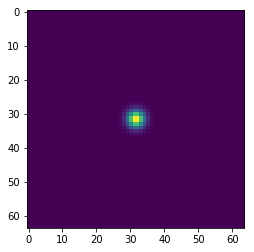

In [9]:
plt.imshow(im_epsf.array)

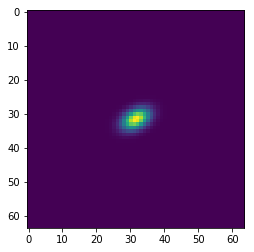

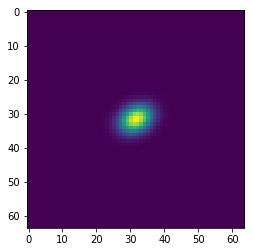

In [10]:
im_gal = galsim.ImageF(image_size,image_size)
image_gal = gal.drawImage(image=im_gal,scale=pixel_scale,method='no_pixel')
plt.imshow(image_gal.array,interpolation="none");plt.show()
plt.imshow(image.array,interpolation="none")

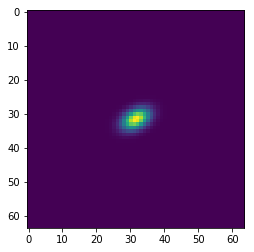

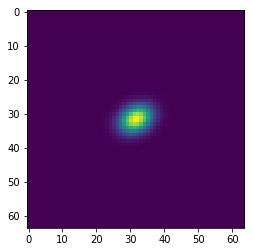

In [11]:
im_gal = galsim.ImageF(image_size,image_size)
image_gal = gal.drawImage(image=im_gal,scale=pixel_scale,method='no_pixel')
plt.imshow(image_gal.array,interpolation="none");plt.show()
plt.imshow(image.array,interpolation="none")

In [12]:
numNoiseRealizations = 10#00 #Number of noise realizations to average
#noiseSigmaArr = np.linspace(0,10000,51)
snrArr = np.arange(10,201,1) #array of SNRs to calculate average measured ellipticities for

No Noise


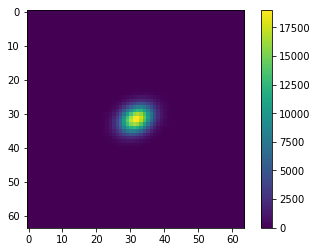

SNR:  10
Standard devation:  9859.46650051899


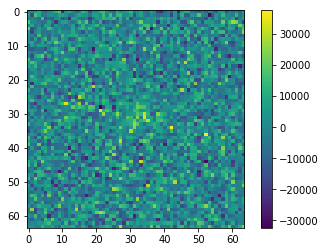

In [13]:
snr1=10
print('No Noise')
plt.imshow(image.array);plt.colorbar();plt.show()
nss=[]
for x in range(1):
    noise_im = image.copy()
    ns=galsim.GaussianNoise(sigma=1)
    nvar=noise_im.addNoiseSNR(ns,snr1,preserve_flux=True)
    nss.append(noise_im.array)
kaixo=np.mean(np.array(nss),axis=0)
print 'SNR: ',snr1
plt.imshow(kaixo);plt.colorbar()
print 'Standard devation: ',np.sqrt(nvar)

In [14]:
res=[]
errList=[]
failures=[]
noiseVar=[]
zz=0
print(len(snrArr))
#loop through signal-to-noise ratios
for snr in snrArr:
    print(zz) #counter
    zz+=1
    #noiseArr = [galsim.GaussianNoise(sigma=noiseSigma) for i in range(numNoiseRealizations)]
    obs=[] #list of shape results for this snr
    #imstemp=[]
    for i in range(numNoiseRealizations):
        noise_im = image.copy()
        noise=galsim.GaussianNoise(sigma=1) #make a new noise realization
        nvar=noise_im.addNoiseSNR(noise,snr,preserve_flux=True) #add the noise to the image at given snr
        results = galsim.hsm.EstimateShear(noise_im,image_epsf,strict=False, guess_sig_gal=disk_re/pixel_scale, guess_sig_PSF=8.0, shear_est='REGAUSS')

        #if shape estimation successful, add result to obs
        if results.correction_status==0:
            obs.append([results.observed_shape.e1,results.observed_shape.e2,\
                 results.corrected_e1,results.corrected_e2])
        #if shape estimation unsuccessful print a warning and add result to failures
        else:
            print "Failure for ", nvar
            failures.append(results)

    #plt.imshow(noise_im.array);plt.show()
    
    obs=np.array(obs)
    if obs.shape[0]>0:
        #Calculate error
        err = np.std(obs,axis=0) / np.sqrt(obs.shape[0])
        noiseVar.append(nvar) #Record variance used for this SNR
    else:
        err = np.array([0.,0.,0.,0.]) #avoid nans in errList
    errList.append(err)
    #Average shape measurements over all noise realisations for this SNR and add to "res"
    res.append(np.mean(obs,axis=0)) 
    
errArray=np.stack(errList)
errArray=errArray.transpose()
resArr = np.array(res).transpose()

191
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Failure for  541373.8008178669
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


galsim.PositionD(x=0.0, y=0.0)

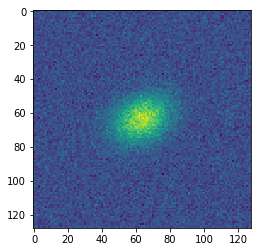

In [103]:
plt.imshow(noise_im.array)

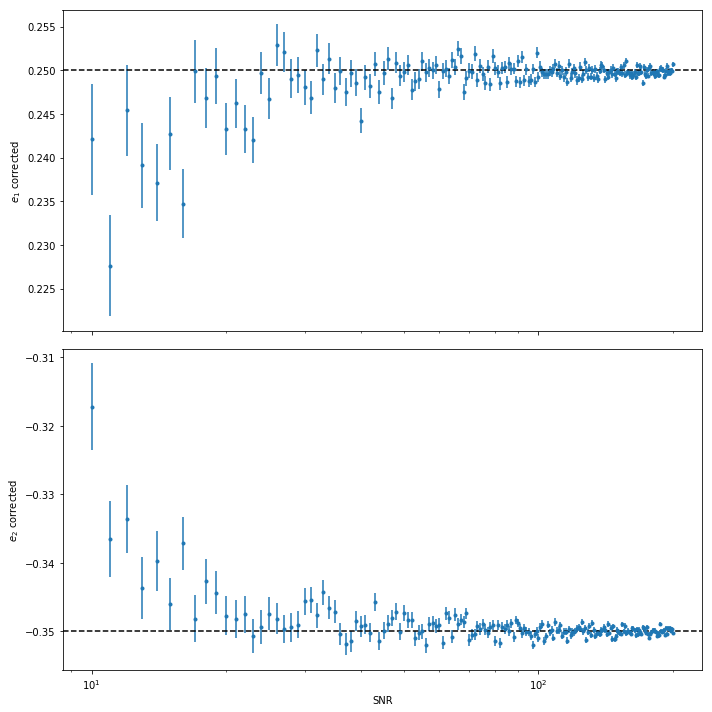

In [143]:
fig,ax=plt.subplots(2,figsize=(10,10),sharex=True)
ylabels1=['$e_1$ observed','$e_2$ observed']
ylabels2=['$e_1$ corrected', '$e_2$ corrected']
lines=[e1,e2]
for i,x in enumerate(resArr[2:]):
    #ax[i].errorbar(np.sqrt(noiseVar),x,yerr=errArray[i],fmt='.')
    ax[i].errorbar(snrArr,x,yerr=errArray[i],fmt='.')
    ax[i].axhline(lines[i],color='k',ls='--')
    ax[i].set_ylabel(ylabels2[i])
    ax[i].set_xscale('log')

plt.xlabel('SNR')
plt.tight_layout()
#plt.savefig('e_vs_sigma_corr_log.png')
plt.show()

Failure rate vs SNR